# Title : Data analysis of biodata

## Author: Sabareesh Mamidipaka

This project is divided in 5 sections:

1. Introduction

2. Exploring The Data

    2.1 The Data

3. Exploratory Data Analysis (EDA)

    3.1 Descriptive Figures

    3.2 Feature Engineering

        3.2.1 Add new features
        
        3.2.2 Feature dependence study

4. Model Selection

    4.1 Data Preparation: Training and Testing Sets

    4.2 Model Selection

        4.2.1 Decision Tree, Random Forest

        4.2.2 Confusion Matrix
5. Actionable Recommendations

# 1. Introduction

The dataset contains the profiles of different people with their seniority level (based on their current jobs), education and their experience. We will try to clean the data, visualize and hopefully draw some insights from the distributions. 

In [1]:
# Importing librairies
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer, fbeta_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import datetime
from wordcloud import WordCloud
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics

%matplotlib inline
import time

In [2]:
def creating_distplot(size, data, features):
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.distplot(data[features[i]])
        
def creating_countplot(size, data, features):
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.countplot(data[features[i]],order=data[features[i]].value_counts().index)
        

# 2 Exploring the Data

## 2.1 The Data

Load the data and check the structure and features

In [3]:
# Loading the data
biodata = pd.read_json("seniority_train.json", lines=True)
biodata.head()

,seniority_level,education,experience
0,Entry,[],"[{'skills': ['production', 'labor', 'floors', ..."
1,Senior,"[{'school': 'University of Nebraska at Omaha',...","[{'skills': [], 'time': ['Apr 2019', 'Present'..."
2,Mid-Level,"[{'school': 'Tyee High School SeaTac', 'descri...","[{'skills': ['consistent', 'focus', 'safety', ..."
3,Intern,[{'school': 'UNIVERSITY OF ILLINOIS AT URBANA-...,"[{'skills': [], 'time': ['2018-08-01', 'Presen..."
4,Mid-Level,"[{'school': '', 'description': 'GED, 1996 In...","[{'skills': ['inventory control', 'assembly', ..."


Check the data types of the columns and change datatypes if deemed necessary. Also check the number of null values in each column and the quantity.

In [4]:
biodata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29969 entries, 0 to 29968
Data columns (total 3 columns):
seniority_level    29675 non-null object
education          29969 non-null object
experience         29969 non-null object
dtypes: object(3)
memory usage: 702.5+ KB


There are around 300 null values for seniority level which is fairly small number compared to the 30000 odd rows we have. So, we can just drop those rows for the ease of analysis.

In [5]:
biodata.dropna(inplace=True)

# 3. Exploratory Data Analysis

## 3.1 Descriptive figures

Since the only structured variable we have is a categorical variable of seniority level, we can make a countplot of it and check the distribution of seniority.

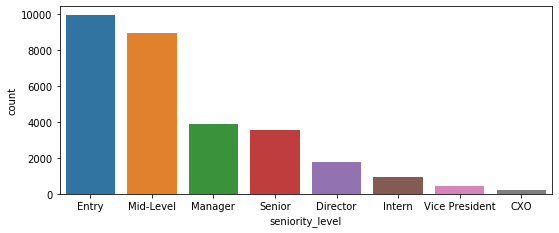

In [6]:
# sns.countplot(biodata['seniority_level'])

creating_countplot((30,20),biodata,['seniority_level'])

Apart from intern, the count of positions decreases continuously with seniority. This is expected as seniority level is basically a heirarchy.

## 3.2 Feature Engineering

We can extract features like major, highest degree, number of jobs and number of companies from the data. 

In [7]:
# The experience for each individual is made into a dataframe and passed into this function.
# This function iterates over each row of the 'time' column and calculates the differnce and sums the values
# to get the total experience in years.

def get_experience(exp_df : pd.DataFrame):
    exp_years = 0
    for i in range(len(exp_df)):
        try:
            if exp_df.time.values[i][1] in ['Present','Current','current']:
                exp_years += (pd.datetime.now()-pd.to_datetime(exp_df.time.values[i][0])).days/365.25
            else:
                exp_years += np.nan_to_num((pd.to_datetime(exp_df.time.values[i][1])-\
                                            pd.to_datetime(exp_df.time.values[i][0])).days)/365.25
        except:
            pass
    return exp_years


# The experience for each individual is made into a dataframe and passed into this function.
# This function iterates over each row of the 'skills' column and takes all unique values to get the skill set.

def get_skill_set(exp_df : pd.DataFrame):
    try:
        skill_set = ' '.join(set(exp_df.skills.sum()))
    except:
        skill_set = ''
    return skill_set

Note: the 'get_experience' function calculates the total experience assuming that the person does full time work at all listings. We need to discuss with the client to see if they think its a valid assumption since the definition o experience is subjective. But the current function may rise to give some bias in 'years of experience' which we can discuss later.

In [8]:
# The education for each individual is made into a dataframe and passed into this function.
# This function iterates over each row of the 'degree' column and tries to group into one of the categories.

def get_degree(x):
    
    # Check further if 'degree' is given. Else return '-1' corresponding to missing information.
    if x:
        
        # If length of degree is less than 6 characters, it means that the user has entered it as 'B A' or 'B S', etc.
        # So, we remove any spaces for the convenience of classification.
        if len(x)<=6:
            x = x[:6].replace(' ','') 
            
        # We now look for keywords like 'MBA', 'Master of Bus'iness, 'Master in Busi'ness to classify into MBA.
        if any(keyword.casefold() in x.casefold() for keyword in ['MBA','Master of Bus', 'Master in Bus']):
            return 7
        elif any(keyword.casefold() in x[:6].casefold() for keyword in ['Master', 'MS', 'ma']):
            return 6
        elif any(keyword.casefold() in x[:8].casefold() for keyword in ['Bachelor','BS','ba']):
            return 5
        elif any(keyword.casefold() in x.casefold() for keyword in ['certific']):
            return 2
        elif any(keyword.casefold() in x.casefold() for keyword in ['diploma']):
            return 4
        elif any(keyword.casefold() in x.casefold() for keyword in ['associa','aa']):
            return 3
        elif any(keyword.casefold() in x.casefold() for keyword in ['ged']):
            return 2
        elif any(keyword.casefold() in x.casefold() for keyword in ['phd','doctor']):
            return 8
        elif any(keyword.casefold() in x.casefold() for keyword in ['high_school', 'high school']):
            return 1
        else: return 0
    return -1

Note: In the above function, we could have used complete keywords like 'Master of Business' but that is not necessary and this saves time. Also the returned value '7' corresponds to the level of education. We are not going in the order of education 
for better classification. For example, a student with 'Master in Business' can be classified into Masters if the masters criterion is used for classification first. Taking these factors into consideration, I changed the order of classification. Others are self explanatory.

You can see the mapping in the dictionary below.

In [9]:
education_map = {1:'High School', 2:'Certification', 3:'Associate', 4:'Diploma',\
                5:'Bachelors', 6:'Masters', 7:'MBA', 8:'PhD', 0:'Other', -1:'Missing'}

We will now write a function to get the major from the degree listed. To do this, we will remove all the words which possible describe the education like Bachelors, Masters as well as other articles and other prepositions.

In [10]:
stopwords = ['bachelor', 'bachelors', 'ba', 'bs', 'master', 'masters', 'ms', 'ma', 'mba', 'phd', 'science', 'associate', \
             'associates', 'certification', 'degree', 'arts', 'diploma', 'high_school', 'certificate', 'of', 'in', 'the', \
             'business', 'high', 'school', 'doctor']

In [11]:
def get_major(x):
    
    # If the length of the degree is less than 4 characters, then he most probably never described his major and just
    # listed his degree, we can mark these cases as missing without further processing.
    if len(x)>=4:
        
        # Remove all the words which are listed in the list 'stopwords' above.
        x_words = x.split()
        resultwords  = [word for word in x_words if word.lower() not in stopwords]
        result = ' '.join(resultwords)
        
        # Then check the remaining string for keywords and classify accordingly.
        if any(keyword.casefold() in result.casefold() for keyword in ['engineering','electr','mecha','comput']):
            return 'stem'
        if any(keyword.casefold() in result.casefold() for keyword in ['bio','chem','physics','statistics','math','appl']):
            return 'sciences'
        if any(keyword.casefold() in result.casefold() for keyword in ['business','marketing','account']):
            return 'marketing'
        if any(keyword.casefold() in result.casefold() for keyword in ['administration','manage']):
            return 'administration'
        if any(keyword.casefold() in result.casefold() for keyword in ['finan','econom']):
            return 'economics'
        if len(result)>5:
            return 'other'
    return 'notKnown'

The order of classification is again such that classification would be as accurate as possible. For example, a student with bioengineering would be classified into 'stem' rather than pure biology stream.

In [12]:
# This function takes in the education dataframe and removes unnecessary special charecters  like '.',',',etc.
def pre_process(edu_df : pd.DataFrame, column):
    edu_df[column] = edu_df[column].str.replace('.','')
    edu_df[column] = edu_df[column].str.replace("\'","")
    edu_df[column] = edu_df[column].str.replace("\,","")
    edu_df[column] = edu_df[column].str.replace("\'","")
    edu_df[column] = edu_df[column].str.replace("\-","")
    edu_df[column] = edu_df[column].str.replace("\n"," ")
    edu_df[column] = edu_df[column].str.replace("\t"," ")
    return edu_df

In [13]:
# Takes in the education dataframe and extracts education degree and major from the 'degree' column.
def get_edu_and_major(edu_df : pd.DataFrame):
    
    # Default education and major is missing and notKnown
    max_edu_int = -1
    major = 'notKnown'

    # We go further only if we have any information about the education history
    if len(edu_df)>0:
        
        # preprocess to remove any special characters
        edu_df = pre_process(edu_df, 'degree')
        
        # Get all the education degrees and select the highest degree he/she obtained.
        max_edu_int = np.max(edu_df['degree'].apply(get_degree))
        
        # If the education is missing, then no need to worry about finding the degree
        if max_edu_int!=-1:
            
            # Check for any cases of a person doing two degrees and extract all those rows
            max_deg_df = edu_df[edu_df['degree'].apply(get_degree)==max_edu_int]
            
            # Get the major for all these rows and remove any duplicates to get all unique majors
            major = ' '.join(set(max_deg_df['degree'].apply(get_major)))
    
    # Since, we are done with comparisons, we can get back the education as a string.
    max_edu = education_map[max_edu_int]
    
    return max_edu, major

In [14]:
# This function takes in the education dataframe of an individual and returns the number of unique companies 
# and the number of jobs he has had.
def get_num_jobs_and_comp(exp_df : pd.DataFrame):
    
    # default value of 0 for number of companies
    num_comp = 0
    
    # if he has any experience, get the number of unique companies he has worked for.
    if len(exp_df)>0:
        num_comp = exp_df.work.nunique()
    return len(exp_df), num_comp

In [15]:
# this function takes in each row of the dataframe and calls all the necessary functions to get all the required
# information like skill_set, years of experience, etc.

def extract_info(x):
    exp_df = pd.DataFrame.from_dict(x["experience"])
    
    skill_set = get_skill_set(exp_df)
    
    exp_years = get_experience(exp_df)
    
    num_jobs, num_comp = get_num_jobs_and_comp(exp_df)
    
    # we are interested in only the degree to get major and education
    edu_df = pd.DataFrame.from_dict(x["education"])

    max_edu, major = get_edu_and_major(edu_df)

    return skill_set, exp_years, max_edu, major, num_jobs, num_comp

problem of repeated experience if someone is doing two jobs at once.

In [16]:
# Extract all the information and store them as columns for the dataset
biodata['skill_set'],biodata['years_experience'], biodata['degree'], biodata['major'],\
biodata['num_jobs'], biodata['num_company']= zip(*biodata.apply(extract_info, axis=1))

Verify visually if the information was succesful. 

In [17]:
biodata.head()

,seniority_level,education,experience,skill_set,years_experience,degree,major,num_jobs,num_company
0,Entry,[],"[{'skills': ['production', 'labor', 'floors', ...",safety lunch truck production labor floors cle...,4.876112,Missing,notKnown,3,3
1,Senior,"[{'school': 'University of Nebraska at Omaha',...","[{'skills': [], 'time': ['Apr 2019', 'Present'...",action sales team range planning wip competiti...,12.536619,MBA,administration,7,6
2,Mid-Level,"[{'school': 'Tyee High School SeaTac', 'descri...","[{'skills': ['consistent', 'focus', 'safety', ...",team quality production materials safe cart ba...,7.874059,Missing,notKnown,5,5
3,Intern,[{'school': 'UNIVERSITY OF ILLINOIS AT URBANA-...,"[{'skills': [], 'time': ['2018-08-01', 'Presen...",apparel regression governance quality china re...,1.957563,Masters,economics,4,4
4,Mid-Level,"[{'school': '', 'description': 'GED, 1996 In...","[{'skills': ['inventory control', 'assembly', ...",pick checks freight plastics picker operate fo...,14.962355,Certification,notKnown,5,3


### Sanity check.

Remove those rows which are unlikely to happen and are most probably errors to be able to perform a proper analysis.
For example, it is unlikely for a person to have more than 70 years of experience. Remove these outlier values

In [18]:
biodata = biodata[biodata['years_experience']<70]

In [19]:
# This function is applied to each line of the description to split the words and just leaves the words which might be meaningful.
def get_description(x):

    # Filters out to only keep the alphebets and spaces. Removes all other special charecters including numbers.
    x = re.sub('[^A-Za-z ]+', '', x)
    
    # Make a list of remaining words
    x_words = x.split()
    
    # Removes the articles and prepositions and other words since they are length is less than 3  
    resultwords  = [word for word in x_words if len(word)>3]
    
    # joins the list of words to form a string and returns it
    x = ' '.join(resultwords)
    return x

# This function takes in the experience of the person as a dataframe and takes out the description  
def extract_desc(x):
    global des_words
    
    # we are interested in only the description
    edu_df = pd.DataFrame.from_dict(x["experience"])
    
    # further processing only if there is some experience
    if len(edu_df)>0:
        
        # remove unwanted characters 
        edu_df = pre_process(edu_df,'description')
        
        # append the description words to the string 'des_words'
        des_words += ' '.join(edu_df['description'].apply(get_description))

In [ ]:
# All the words in the description will get appended to des_words
des_words = ''
_ = biodata.apply(extract_desc, axis=1)

Word cloud for the skill set. Database, project mangement, customer service seems to be some of the most common skills. This means that while these skills are good to have, these might not be the differentiating skills between candidates. Also, these skills can be considered as essential skills to have.

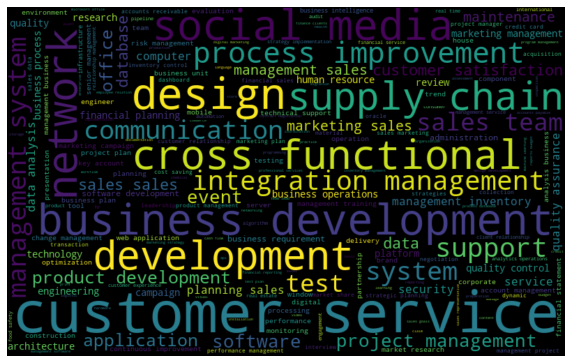

In [23]:
all_words = ' '.join([text for text in biodata['skill_set']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

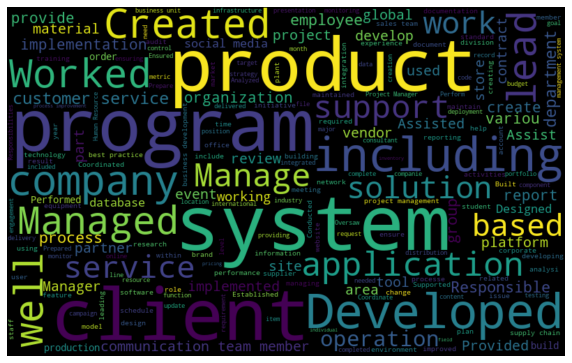

In [24]:
# Word cloud of the description.
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(des_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

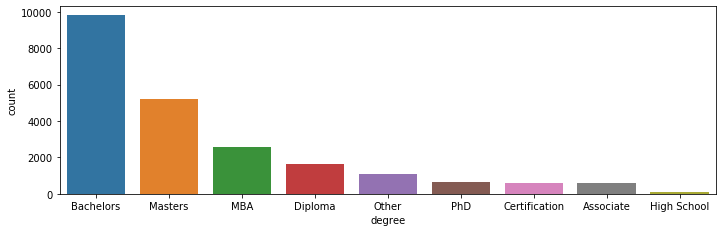

In [21]:
creating_countplot((40,20),biodata[biodata['degree']!='Missing'],['degree'])

Bachelors degree seems to be the most prevelant. The low number of people with high school and Associate degree shows the importance of education.

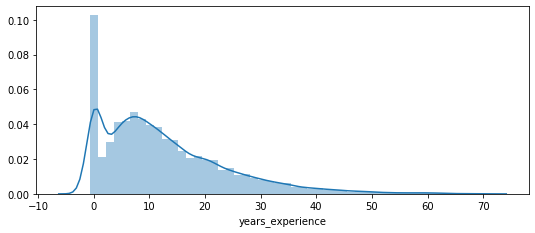

In [22]:
creating_distplot((30,20),biodata,['years_experience'])

Considering that most people are at Entry level, it is not surprising that there is a peak near 0.

In [23]:
order_seniority = ['Intern', 'Entry', 'Mid-Level', 'Senior','Manager', 'Director', 'Vice President', 'CXO']
order_edu = ['High School', 'Certification', 'Associate','Diploma', 'Bachelors', 'Masters', 'MBA', 'PhD', 'Other']

Let's consider only the data where education information is provided to avoid having any bias in the analysis.

Text(0.5, 1.02, 'Distribution of education level for each seniority level.')

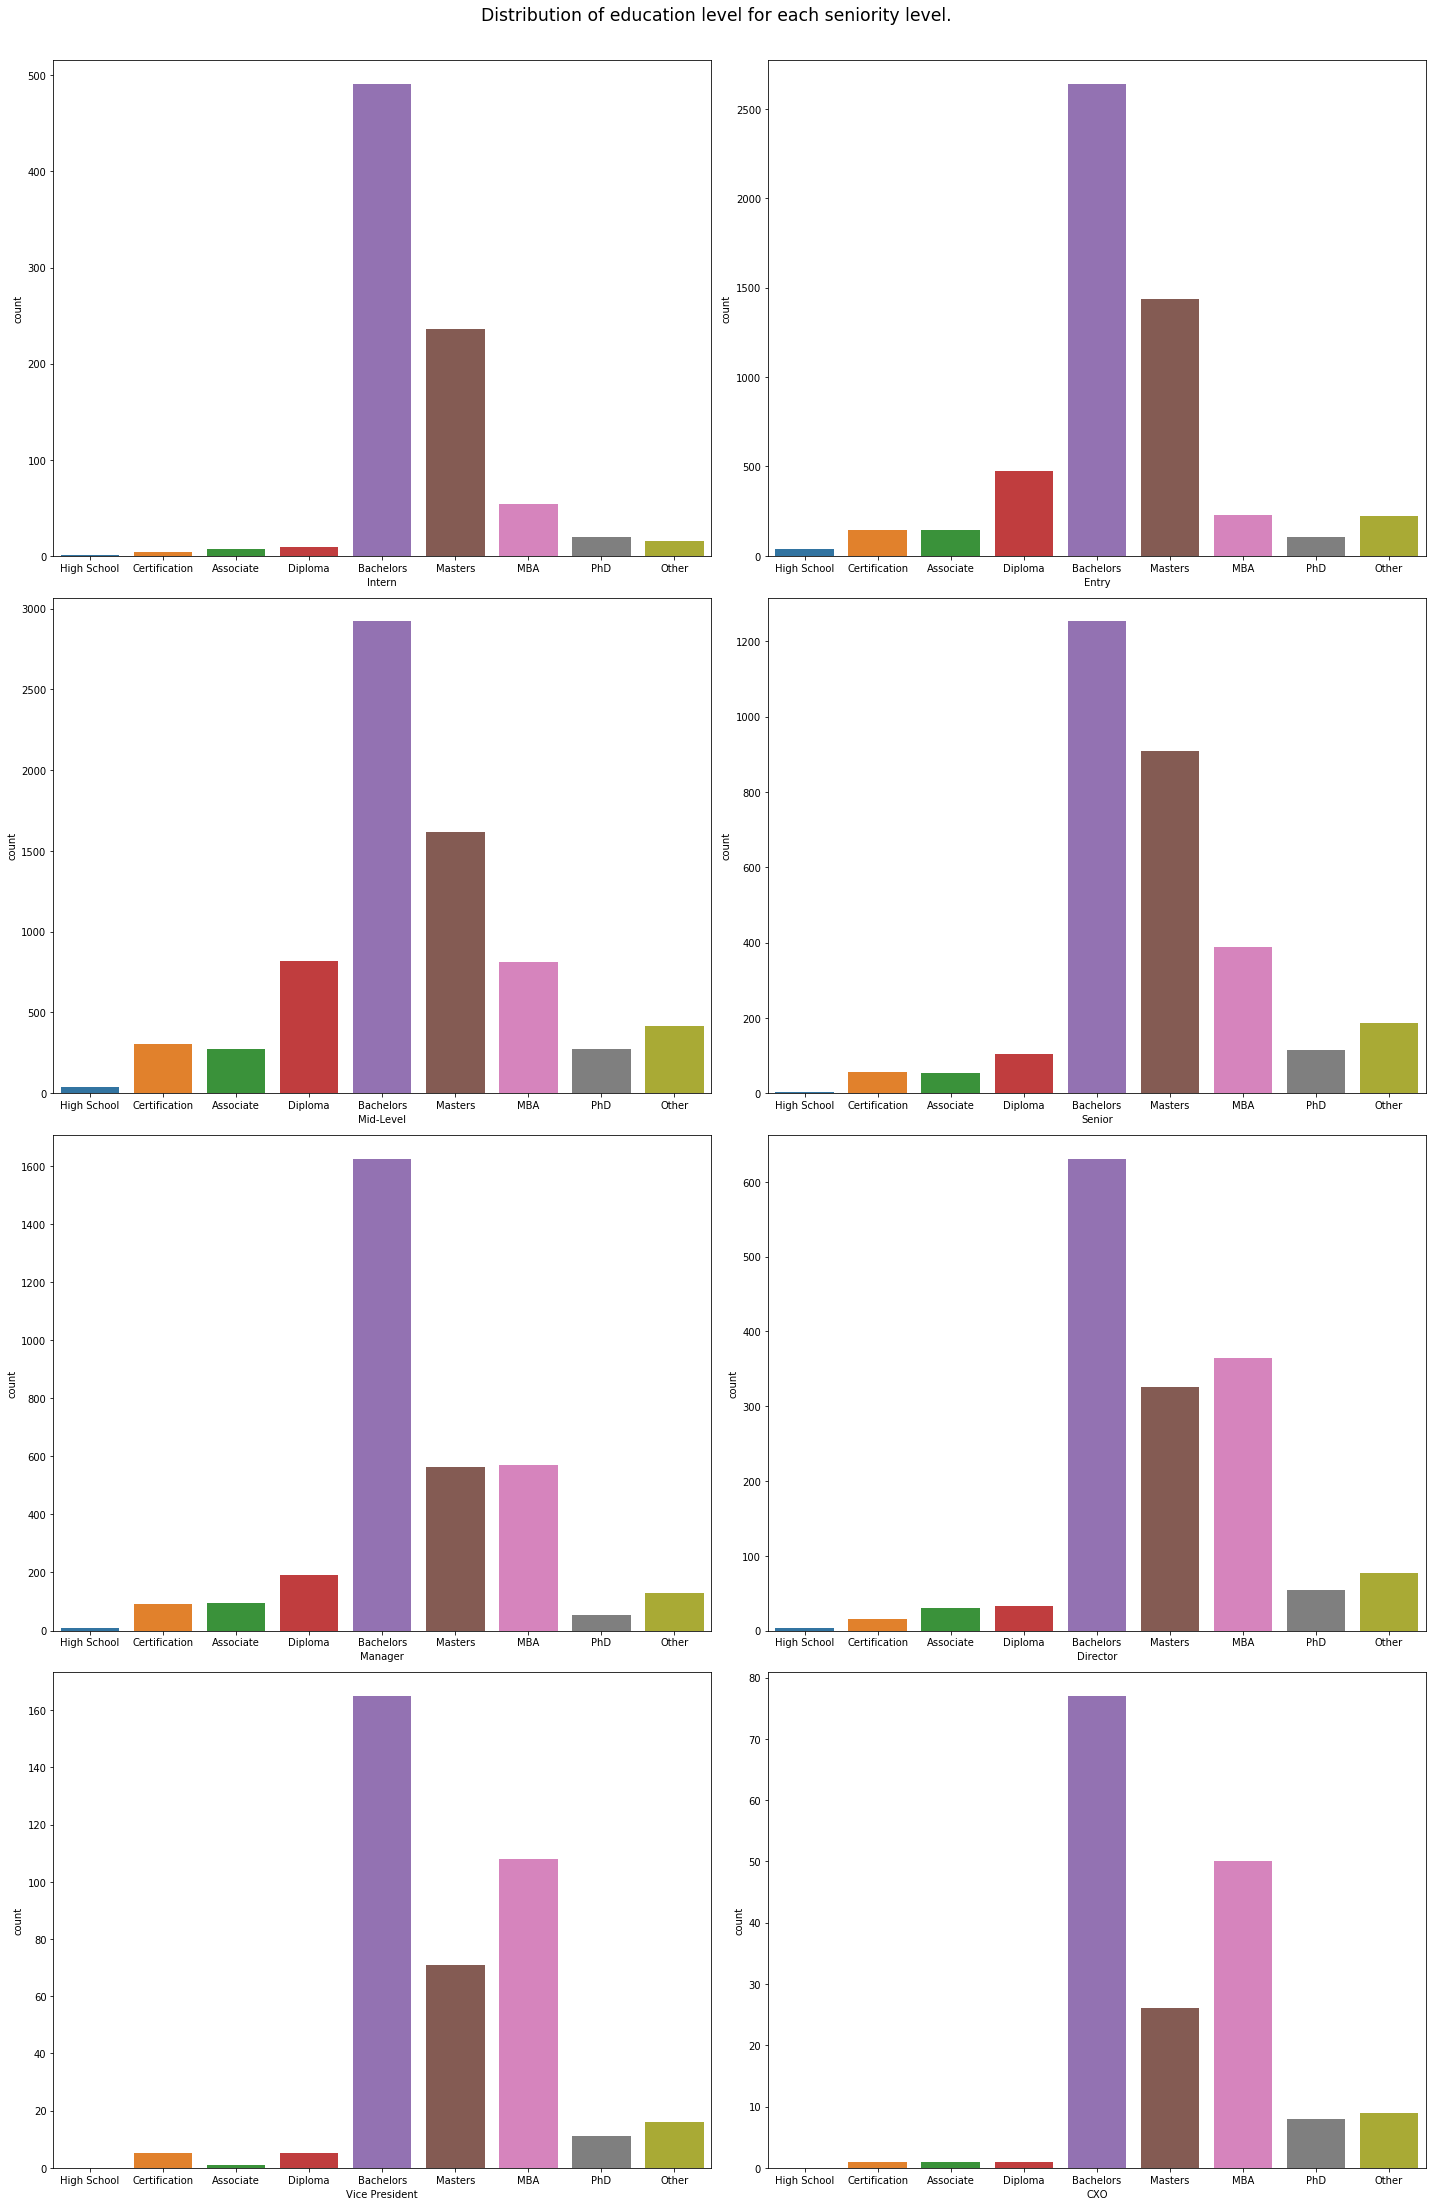

In [24]:
biodata_edu = biodata[biodata['degree']!='Missing']
plt.figure(figsize=(20,30))
for i in range(len(order_seniority)):
    plt.subplot(4, 2, i+1)
    ax = sns.countplot(biodata_edu[biodata_edu['seniority_level']==order_seniority[i]]['degree'],\
                       order=order_edu)
    ax.set_xlabel(order_seniority[i])
    plt.tight_layout()

plt.suptitle('Distribution of education level for each seniority level.', y=1.02, fontsize='xx-large')


In [25]:
biodata_edu['degree'].value_counts()

Bachelors        9804
Masters          5188
MBA              2578
Diploma          1637
Other            1075
PhD               639
Certification     616
Associate         607
High School        90
Name: degree, dtype: int64

Interesting thing we can see here is that most jobs are dominated by people who have done their Bachelors. This should not be surprising since the number of people with bachelors, masters or more than the other types of education like MBA or PhD. But what we see subsequently is that higher level jobs like Manager, Director, Vice-President or CXO, there are more people with MBA degree than people with Masters degree. And this inspite of the fact that there are more people with Masters than MBA. 

This tells that as the seniority level increases, the management aspect of the job becomes more and more important and helps people with MBA succeed more.

Text(0.5, 0.98, 'Distribution of education level for each seniority level.')

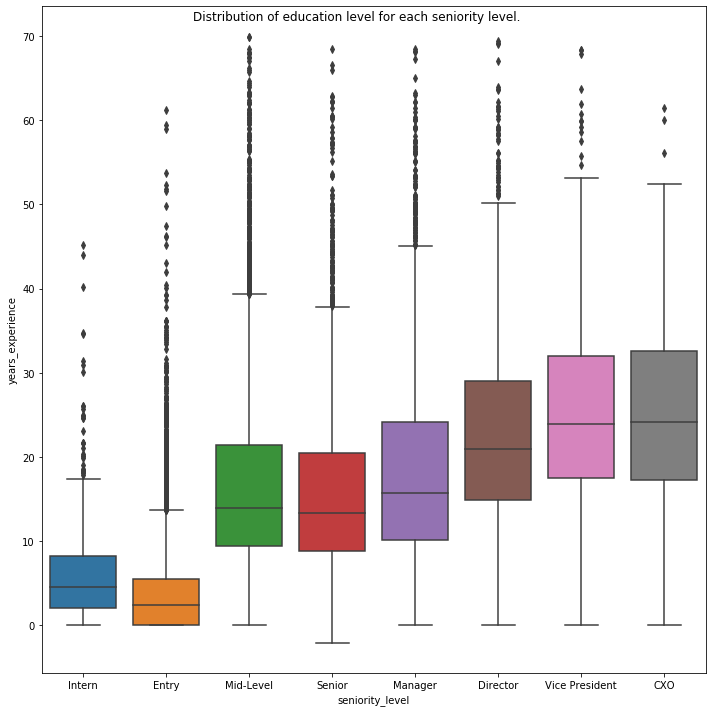

In [26]:
plt.figure(figsize=(10,10))
plt.subplot(1, 1, 1)
ax = sns.boxplot(y='years_experience',x='seniority_level',data=biodata, order=order_seniority)
plt.tight_layout()
plt.suptitle('Distribution of education level for each seniority level.')

Apart from the initial blip of 'Entry' having less experience than 'Intern', the trend is pretty much what you would expect with experience increasing with each level. This is logical since it takes time for someone to rise to higher ranks and hence will have gained higher experience.

Let us now see if education actually helps you to offset the experience needed. If educationdoes help in faster ascension, then  

Text(0.5, 1.02, 'Distribution of years of experience vs education for each seniority level.')

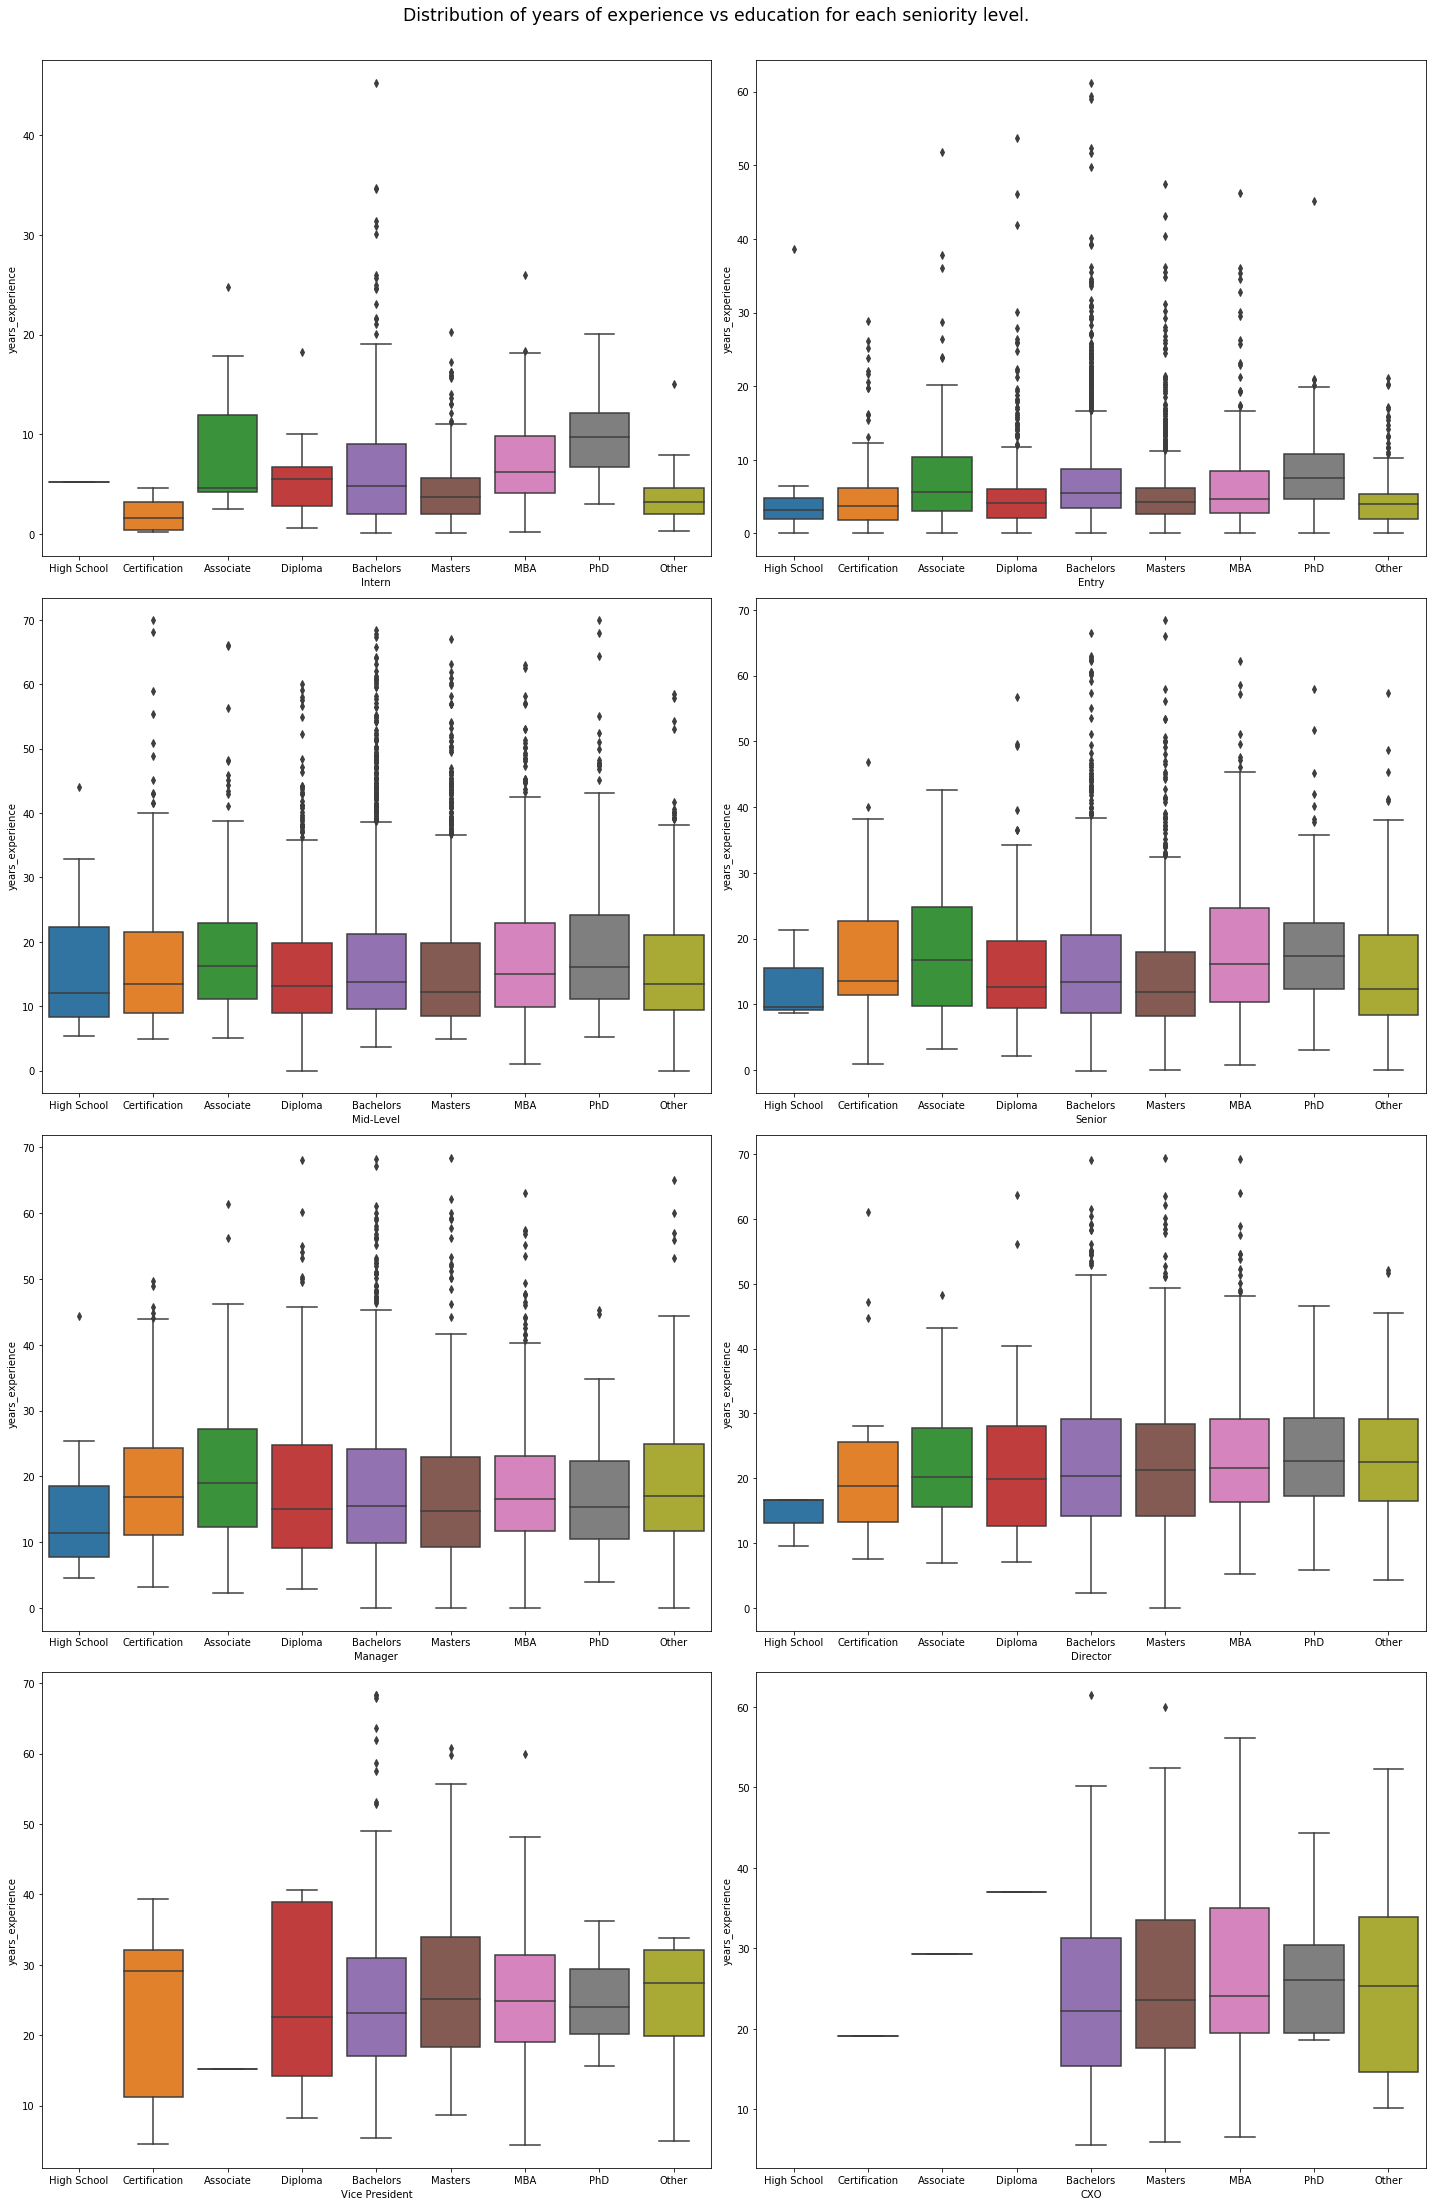

In [27]:
plt.figure(figsize=(20,30))
for i in order_seniority:
    plt.subplot(4, 2, order_seniority.index(i)+1)
    ax = sns.boxplot(y='years_experience',x='degree',data=biodata_edu[biodata_edu['seniority_level']==i],\
                       order=order_edu)
    ax.set_xlabel(i)
    plt.tight_layout()

plt.suptitle('Distribution of years of experience vs education for each seniority level.', y=1.02, fontsize='xx-large')


These graphs are interesting since they seem to suggest that inspite of some people having higher education like PhD, MBA, they still need the same years experience as the people with Associate degree or a diploma. This begs the question if it is more useful to start work early and gain knowledge in a hands-on way rather than gain knowledge in a academic setting. 

Text(0.5, 1.02, 'Distribution of seniority level based on degree.')

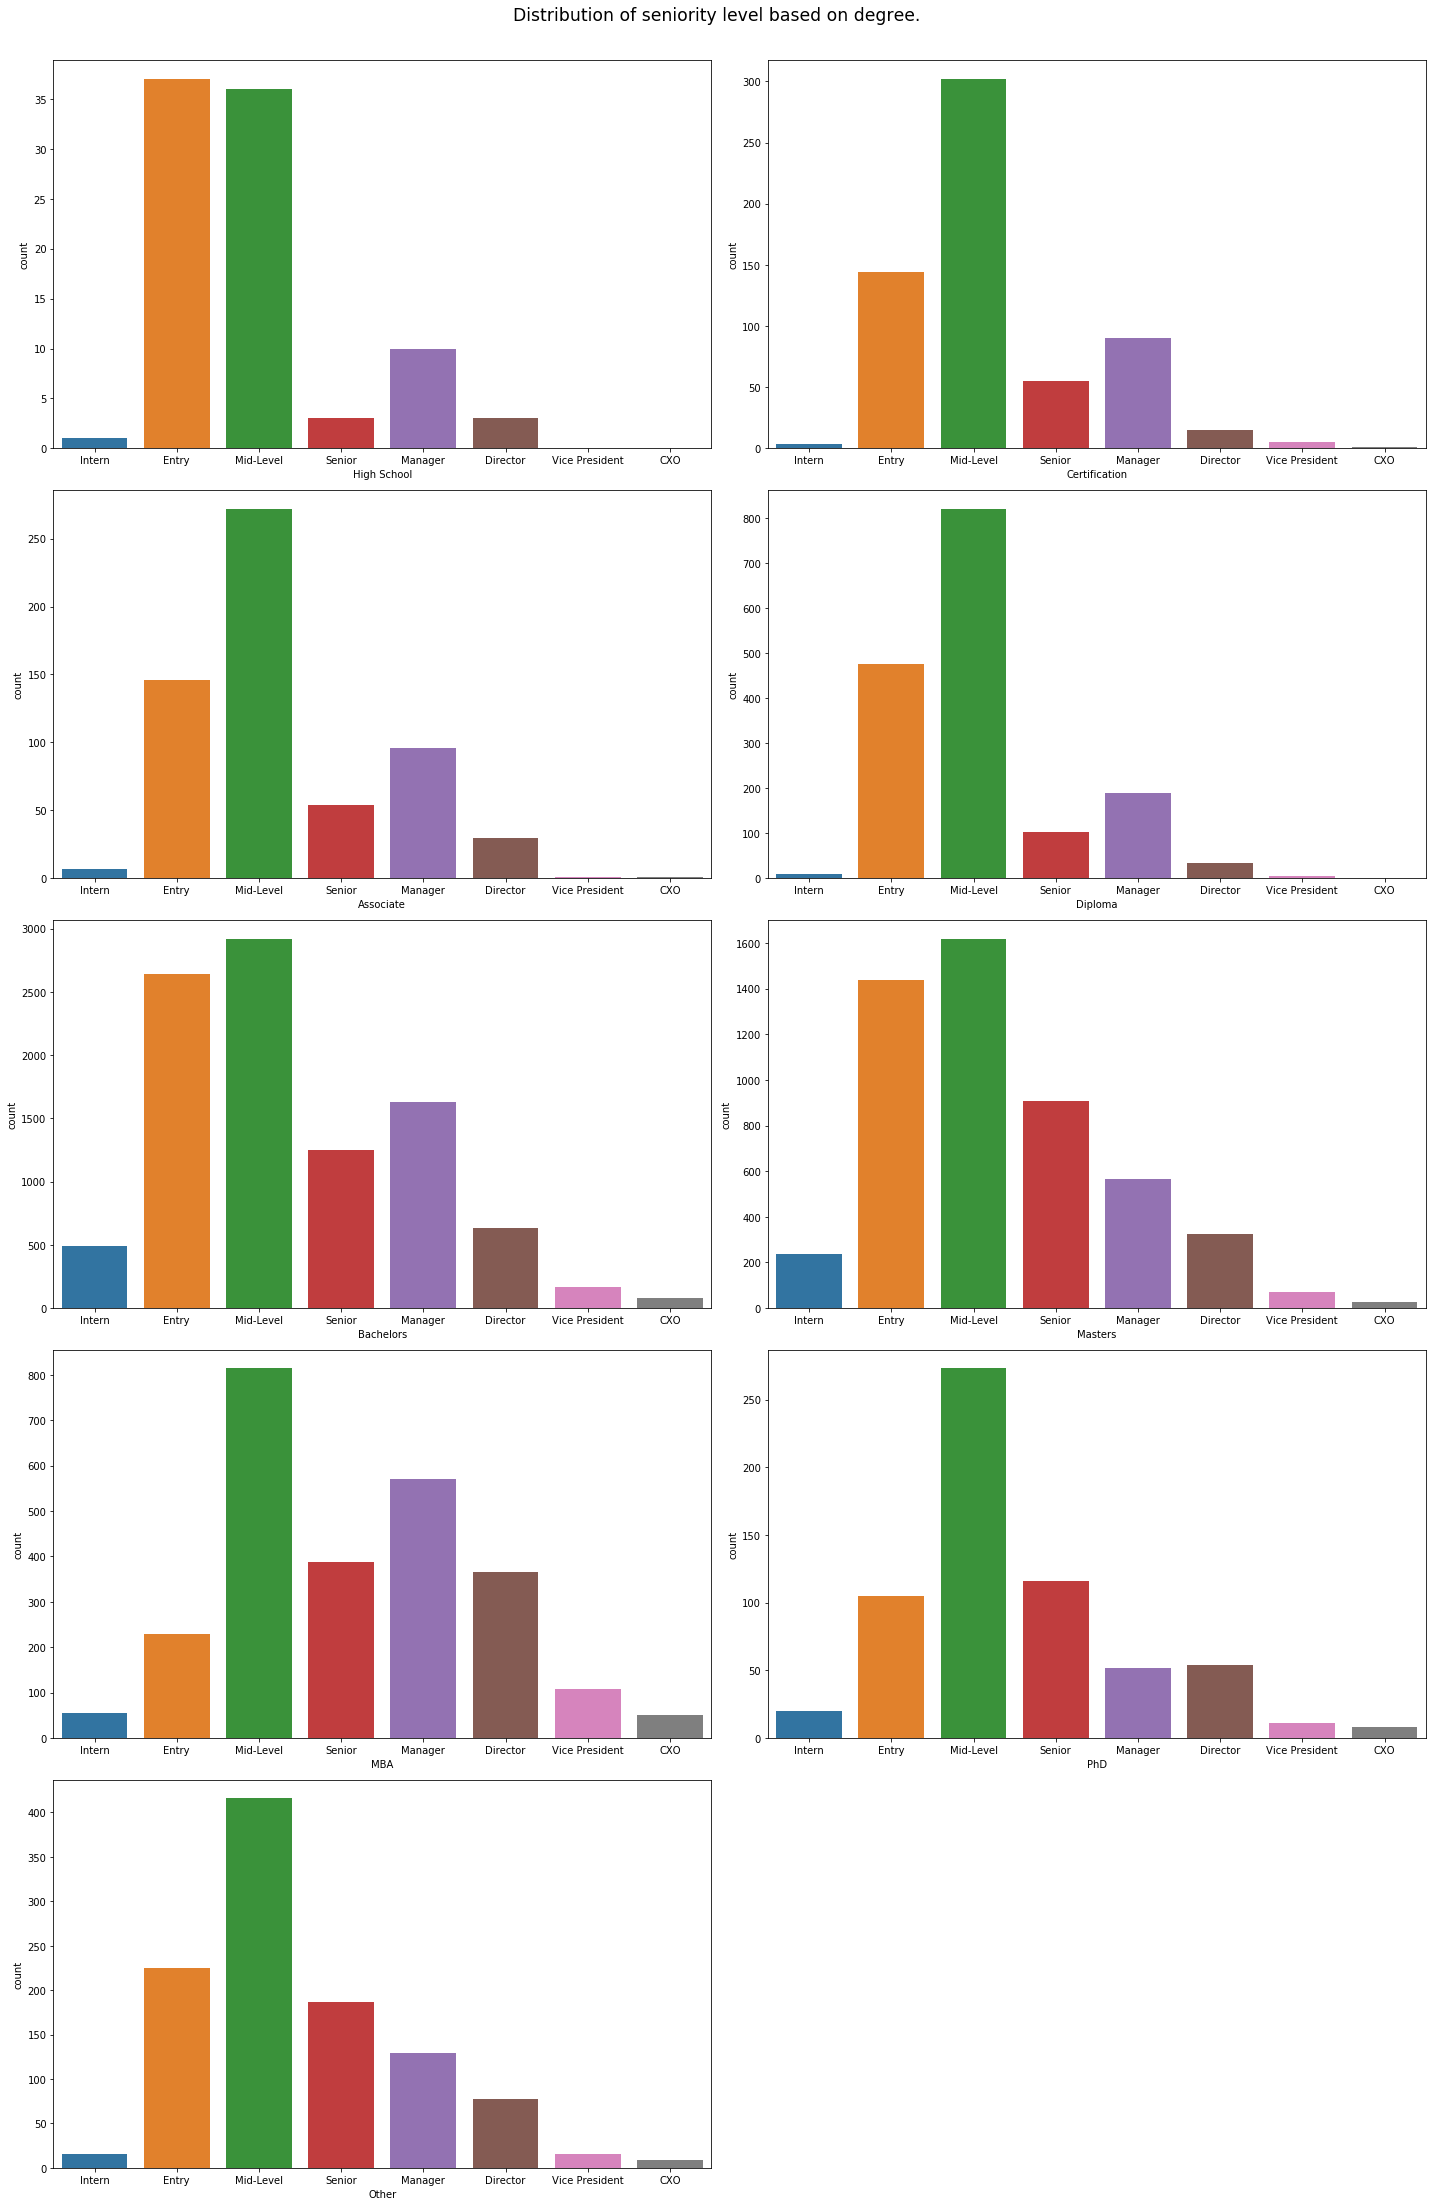

In [28]:
plt.figure(figsize=(20,30))
for i in order_edu:
    plt.subplot(5, 2, order_edu.index(i)+1)
    ax = sns.countplot(biodata_edu[biodata_edu['degree']==i]['seniority_level'],\
                           order=order_seniority)
    ax.set_xlabel(i)
    plt.tight_layout()
    
plt.suptitle('Distribution of seniority level based on degree.', y=1.02, fontsize='xx-large')

The trends seem to suggest that it might be difficult to advance to higher seniority level (Senior or more) unless you have a Bachelor or higher degree. 

Text(0.5, 1.02, 'Distribution of number of skills for each seniority level.')

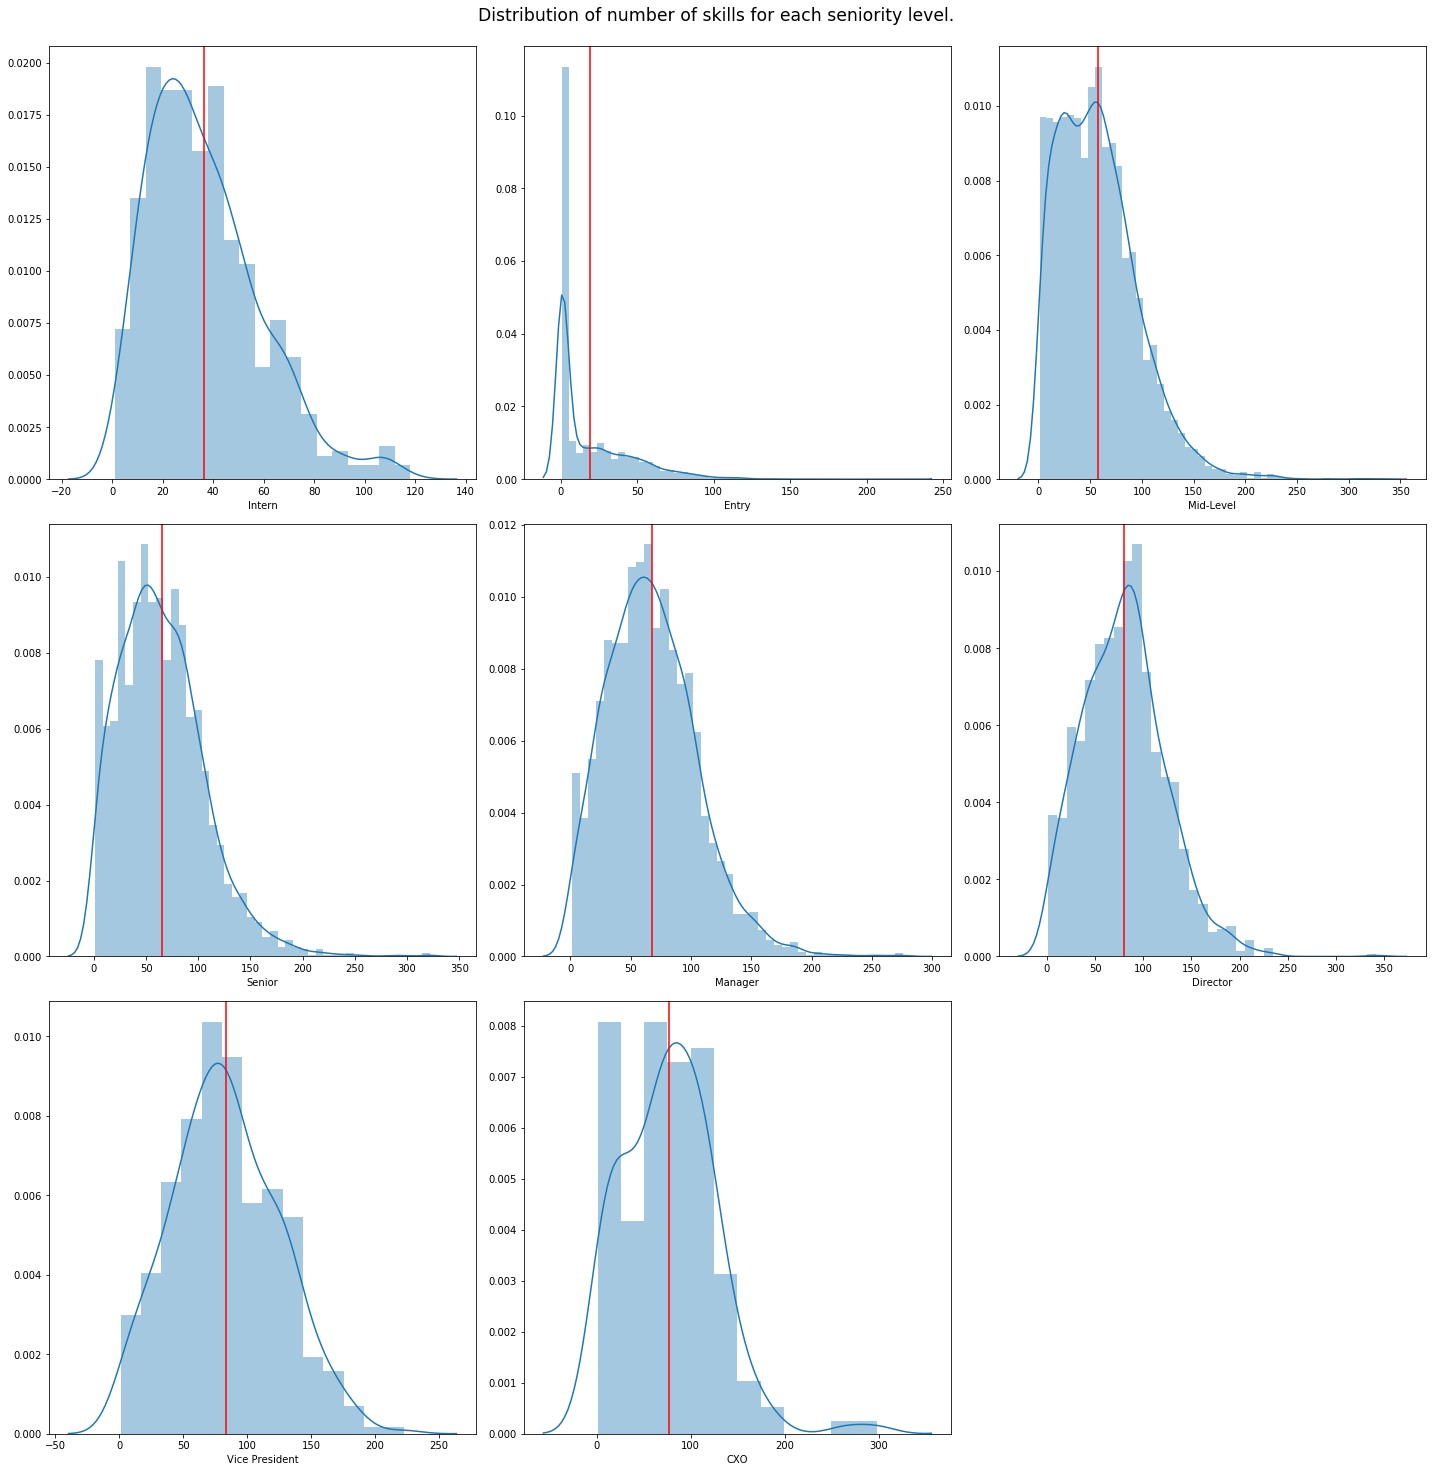

In [29]:
# Consider only the cases where the user specifies the skills used. Some people did not mention the skills used while some
# others did not have any experience. So, we take out the cases where people have experience but skill_set is null.
# Doing this will help us in better visualization without any bias.
biodata_skill = biodata[~((biodata['skill_set']=='') & (biodata['years_experience']!=0))]

plt.figure(figsize=(20,20))
for i in range(len(order_seniority)):
    plt.subplot(3, 3, i+1)
    num_skills = biodata_skill[biodata_skill['seniority_level']==order_seniority[i]]['skill_set'].str.count(' ')
    ax = sns.distplot(num_skills+1)
    ax.set(xlabel = order_seniority[i])
    ax.axvline(num_skills.mean()+1,color='r')
    plt.tight_layout()
plt.suptitle('Distribution of number of skills for each seniority level.', y=1.02, fontsize='xx-large')

Most of the curves are more or less normally distributed around a mean value. And the mean value of the number of skills is gradually increasing with seniority level. This shows that unless you have the hunger and desire to learn continuously, you wont be moving to the next level. 

Text(0.5, 0.98, 'Distribution of number of jobs by seniority level.')

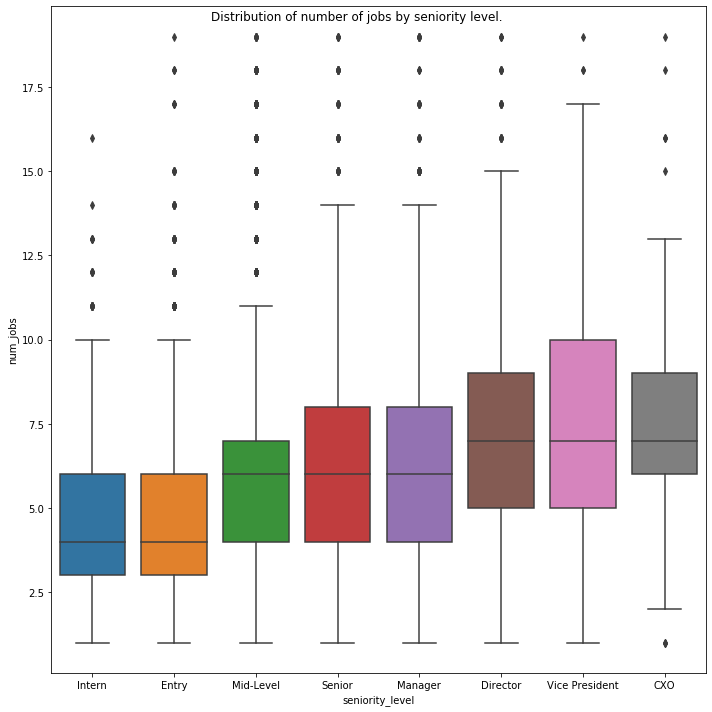

In [30]:
# If someone has more than 20 jobs, then that might be a outlier and at the same time, we cannot judge someone 
# with no experience at all to see how long one stays at a seniority level. So, we filter the biodata accordingly.
biodata_jobs = biodata[(biodata['num_jobs']>0)&(biodata['num_jobs']<20)]

plt.figure(figsize=(10,10))
plt.subplot(1, 1, 1)
ax = sns.boxplot(y='num_jobs',x='seniority_level',data=biodata_jobs, order=order_seniority)
plt.tight_layout()
plt.suptitle('Distribution of number of jobs by seniority level.')

We would expect the number of jobs to increase steadily as the seniority level increases as they need to climb through the heirarchy. We observe the same trend here as well with the number of jobs held increasing with seniority level. But the rise is not as steep or marked as I expected it to be. 

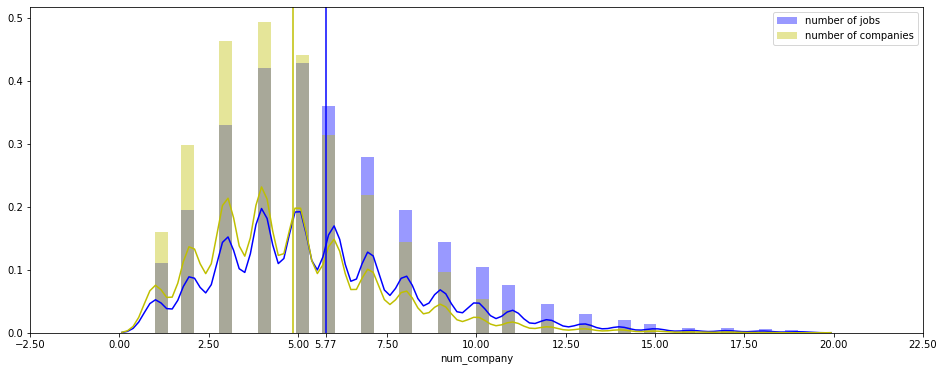

In [31]:
plt.figure(figsize=(16,6))
plt.subplot(1, 1, 1)
ax = sns.distplot(biodata_jobs['num_jobs'], label='number of jobs', color="b")
sns.distplot(biodata_jobs['num_company'], label='number of companies', color="y")
ax.axvline(biodata_jobs['num_jobs'].mean(),color='b')
ax.axvline(biodata_jobs['num_company'].mean(),color='y')
x_ticks = np.append(ax.get_xticks(), biodata_jobs['num_jobs'].mean())
ax.set_xticks(x_ticks)
plt.legend()

This is interesting that the average number of jobs for a person is 5.77 while the average number of companies  person has worked for is around 5. We would always expect that the number of companies is always less than the number of jobs. But the small difference suggests that there is lot of jumping around from one company to another. 

They either feel the need to shift for career growth or there might be some sense of monotonocity developed making the employee shift again.

Text(0.5, 1.02, 'Distribution of years of experience vs education for each seniority level.')

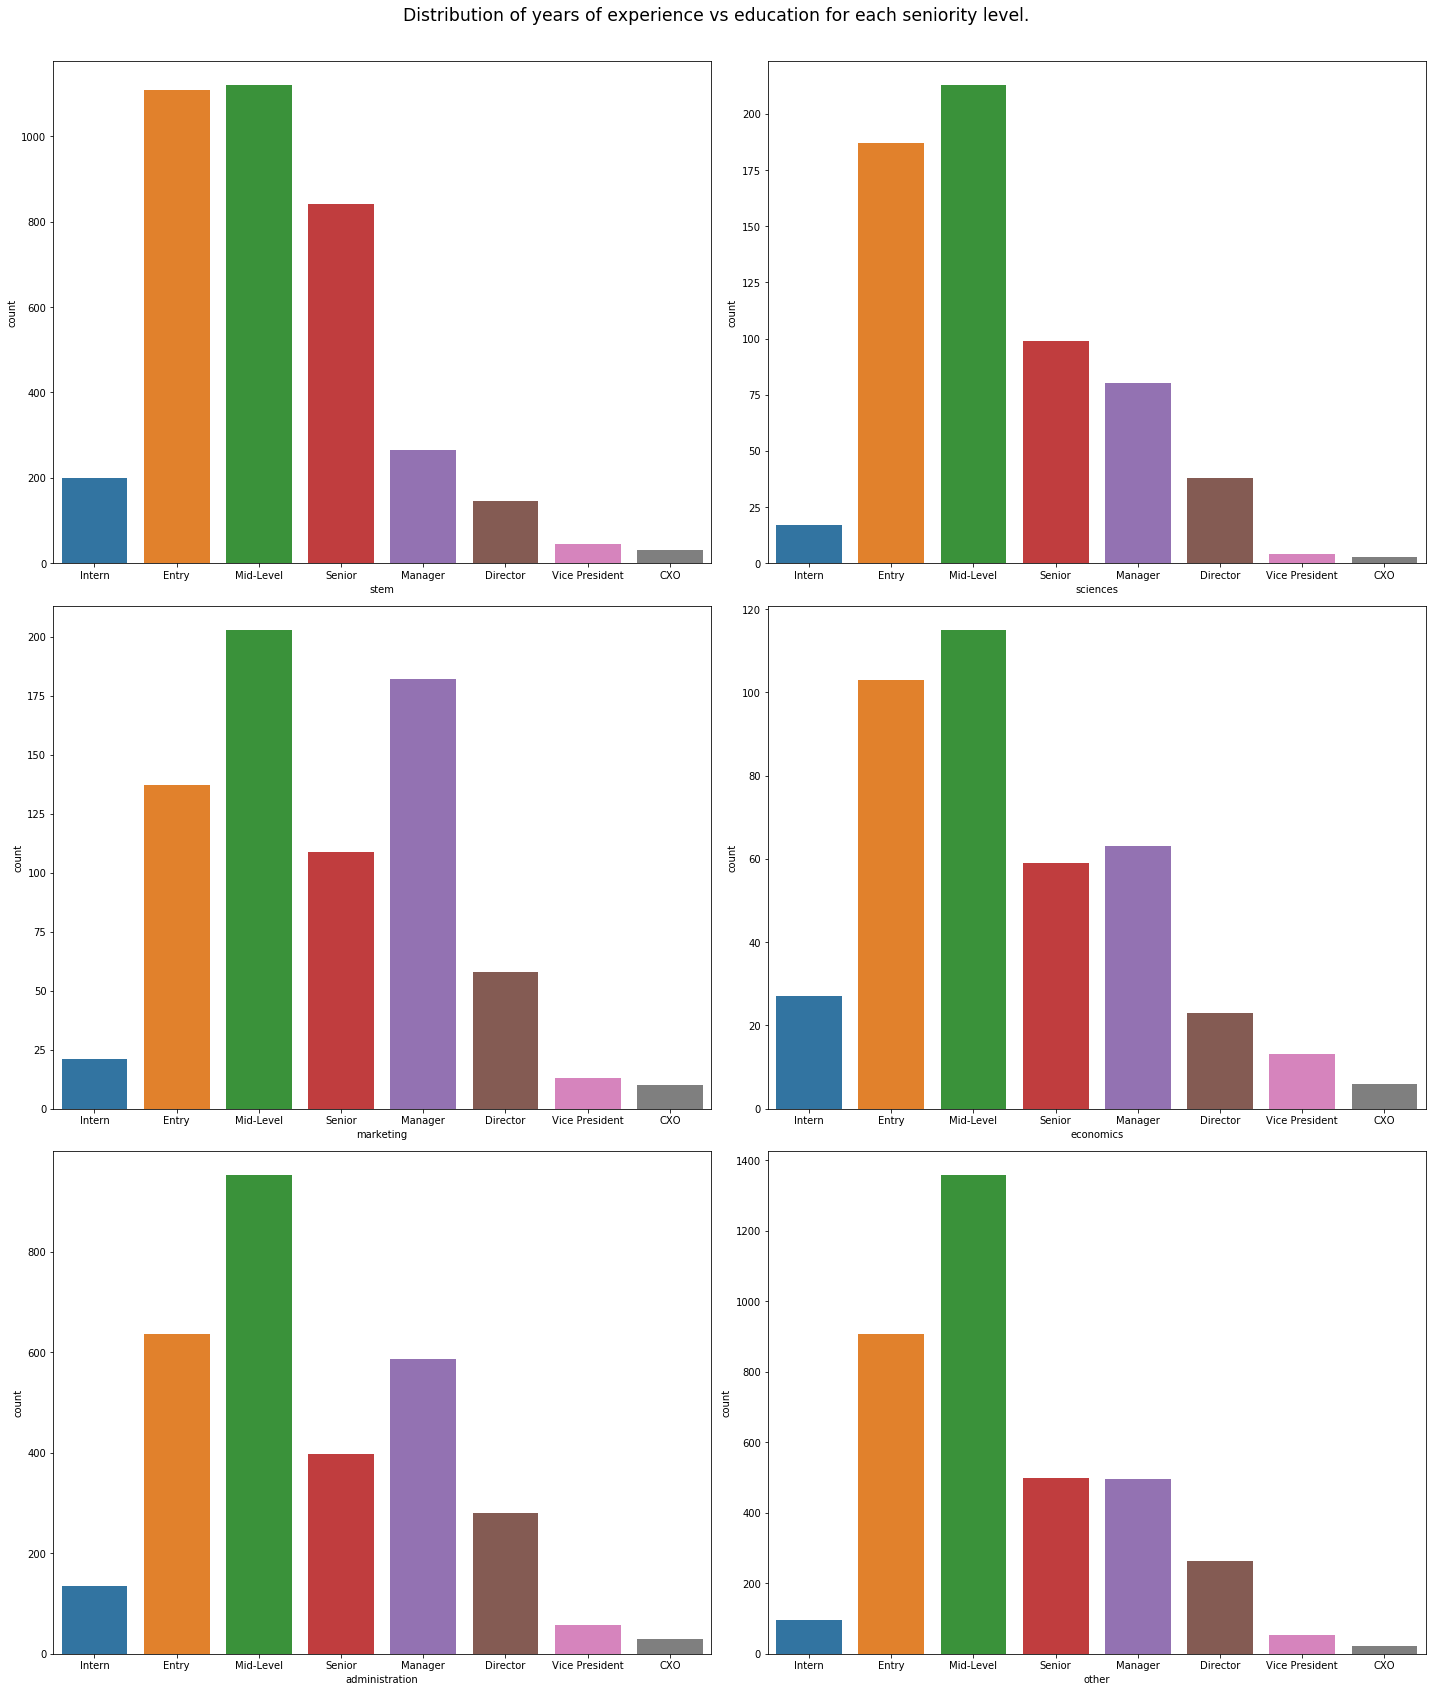

In [32]:
order_major = ['stem', 'sciences', 'marketing', 'economics', 'administration', 'other']
plt.figure(figsize=(20,30))
for i in order_major:
    plt.subplot(4, 2, order_major.index(i)+1)
    ax = sns.countplot(biodata[biodata['major'].str.contains(i)]['seniority_level'],\
                           order=order_seniority)
    ax.set_xlabel(i)
    plt.tight_layout()

plt.suptitle('Distribution of years of experience vs education for each seniority level.', y=1.02, fontsize='xx-large')


We cannot compare the actual numbers since the total number of people in each major are different. But we can definitely compare the trend in each one of them. For example, we can see that people with degree in administration have almost same number of people in entry, mid-level and manager whereas people with stem and sciences have large number of people in entry-level.

People with technical background need to develop non-technical skills as well to advance to higher seniority level!

# 4. Model Selection

We have plotted the variation of seniority level based on different features like num_jobs, major, years of experience and so on. We could not get a very distinct trend but we could definitely see some kind of pattern in each case. 

So, we will try to use these features to predict the seniority level.

One thing we observed throughout these graphs is the Intern level being an exception to the trend. So, I am going to remove this level for the analysis. But let us check the number of cases where we dont have the information regarding education degree or is an intern. This is to make sure we are not throwing out a large chunk of data.

In [33]:
len(biodata[(biodata['degree']=='Missing')|(biodata['seniority_level']=='Intern')])

8209

Although this is appreciable amount of data, we will try to work with the remaining data.

The reason I'm dropping the seniority level 'Intern' is because internship can be done at any stage of the career. Someone might have worked for a few years and might be doing internship for change in career path. Someone might be doing their Masters after working for sometime and doing internship in the meantime. So, it is really hard to predict the possibility of internship. Having 'Intern' seniority level might end up spoiling our model.

## 4.1 Preparing training and testing data

In [34]:
# Remove intern and missing degree cases. We will use the filtered biodata_skill data as we will be considering 
# number of skills as a feature.
model_dat = biodata_skill[~((biodata_skill['degree']=='Missing')|(biodata_skill['seniority_level']=='Intern'))]

In [35]:
# Add the number of skills as a feature by counting the number of spaces in the skill set string
model_dat['num_skills'] = model_dat['skill_set'].str.count(' ')+1

# drop unnecessary features like 'education' and 'experience'
model_dat.drop(['education','experience','skill_set'], axis=1, inplace=True)

C:\Users\sabareesh\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\sabareesh\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [36]:
# Check if any conversions needed to be done based on the datatypes.
model_dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17344 entries, 1 to 29968
Data columns (total 7 columns):
seniority_level     17344 non-null object
years_experience    17344 non-null float64
degree              17344 non-null object
major               17344 non-null object
num_jobs            17344 non-null int32
num_company         17344 non-null int32
num_skills          17344 non-null int64
dtypes: float64(1), int32(2), int64(1), object(3)
memory usage: 948.5+ KB


In [37]:
# Select the dtype of object and convert into categorical data
model_dat[model_dat.select_dtypes(['object']).columns] = model_dat.select_dtypes(['object']).\
                                                apply(lambda x: x.astype('category'))


C:\Users\sabareesh\Anaconda\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [38]:
# We can see that there are few people who have more than one major. So, we cannot do get_dummies directly.
model_dat.loc[49]

seniority_level             Manager
years_experience             6.7488
degree                    Bachelors
major               marketing other
num_jobs                          4
num_company                       4
num_skills                       64
Name: 49, dtype: object

We should make dummies in such a way that if a person does major in more than one department, we will put corresponding value of 1 under both the majors.

Split the string of the major column and stack it. Then take the sum and group it before adding this dataframe to the original dataframe. Then take dummies for degree and concatenate these dummies as well.

In [39]:
splitter = model_dat.major.str.split(' ', expand=True).stack()
model_dat = pd.concat([model_dat, pd.get_dummies(splitter, prefix='d').groupby(level=0).sum()],axis=1)
model_dat = pd.concat([model_dat, pd.get_dummies(model_dat['degree'], drop_first=True)], axis=1)

In [40]:
# Make sure to drop the columns after getting dummies.
model_dat.drop(['degree','major'],axis=1,inplace=True)
model_dat.head()

,seniority_level,years_experience,num_jobs,num_company,num_skills,d_administration,d_economics,d_marketing,d_notKnown,d_other,d_sciences,d_stem,Bachelors,Certification,Diploma,High School,MBA,Masters,Other,PhD
1,Senior,12.536619,7,6,48,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,Mid-Level,14.962355,5,3,28,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
5,Mid-Level,14.458590,6,6,116,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
6,Manager,41.196441,6,3,116,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
8,Senior,7.200548,6,2,108,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


### Split the data into train and test set

In [41]:
# Split the total dataset into train and test
train_data, test_data = train_test_split(model_dat, test_size=0.2, random_state = 0)

In [42]:
# Function for model evaluation.
def summary_metrics(y, y_pred):
    confmat = confusion_matrix(y, y_pred)
    TP = confmat[0,0]
    FN = confmat[0,1]
    FP = confmat[1,0]
    TN = confmat[1,1]
 
    # Print the confusion matrix
    print("Confusion matrix:\n", confmat)
    
    # Print the Accuracy Score
    print("Accuracy:", round(accuracy_score(y, y_pred),2))

    # Print the Sensitivity
    print("Sensitivity:", round(recall_score(y, y_pred, average='micro'),2))

    # Precision
    print("Precision:", round(precision_score(y, y_pred, average='micro'),2))


## Eightfold validation

In [43]:
# Function to perform eightfold validation
def eightfold(model, data: pd.DataFrame, column: str, cv_grid):
    clf = GridSearchCV(model, cv_grid, cv=8)
    clf.fit(data.drop([column],axis=1), train_data[column])
    return clf.best_estimator_

In [44]:
# parameter grid
cv_grid = {'max_depth': [10, 20, 40],
              'min_samples_split': [2, 4, 8],
              'min_samples_leaf': [1, 3, 6]}

# Perform eightfold validation to get the best parameters
Decision_Tree = DecisionTreeClassifier()
Decision_Tree_best = eightfold(Decision_Tree, train_data, 'seniority_level', cv_grid)

tree_predictions = Decision_Tree_best.predict(test_data.drop(['seniority_level'],axis=1))

In [45]:
# Measure the model accuracy.
summary_metrics(test_data['seniority_level'], tree_predictions)

Confusion matrix:
 [[  0   2   2   2  18   3   0]
 [  0  25  12  15 194  13   0]
 [  1   2 582  16 253  15   0]
 [  0  15  64  44 428  18   0]
 [  0  25 115  61 946  55   0]
 [  0  11  77  21 330  44   0]
 [  0   7   0   6  43   4   0]]
Accuracy: 0.47
Sensitivity: 0.47
Precision: 0.47


Let's check if ensemble method does any better.

In [47]:
Random_Forest = RandomForestClassifier(n_estimators=100)
Random_Forest_best = eightfold(Random_Forest, train_data, 'seniority_level', cv_grid)

rf_predictions = Random_Forest_best.predict(test_data.drop(['seniority_level'],axis=1))

In [48]:
# Evaluate the model
summary_metrics(test_data['seniority_level'], rf_predictions)

Confusion matrix:
 [[   0    1    2    0   23    1    0]
 [   0    5    5    4  243    2    0]
 [   0    0  567    0  301    1    0]
 [   0    3   50   10  506    0    0]
 [   0    4   51   12 1134    1    0]
 [   0    0   57    2  418    6    0]
 [   0    0    1    1   57    1    0]]
Accuracy: 0.5
Sensitivity: 0.5
Precision: 0.5


# Actionable Recommendations

Data cleaning: 
a) We could use nltk packages and perform lemmatization to better categorize the majors and degrees.
b) We can try and check if there are any time overlaps in experience and maybe remove them.
c) Better splitting of strings like preserving the term 'operations management' and so on.

Data visualization:
Use plotly or tableau for making the plots interactive

Data analysis:
Look at more relations like whether someone has honors or not. Take specific cases of people who are behaving anamoly and possibly think of reasons for that.

ML model:
Performing better gridsearch. Try different models. Organize the code better by making modules.